In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sales_functions import Standard_PCA, find_max_depth, plot_best_depth

df_og = pd.read_csv('Zara_sales_EDA.csv', sep=';')
df_og.head()

,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,name,description,price,currency,terms,section,season,material,origin
0,185102,Aisle,Yes,clothing,Yes,1243,Zara,https://www.zara.com/us/en/basic-puffer-jacket...,BASIC PUFFER JACKET,Puffer jacket made of tear-resistant ripstop f...,78.99,USD,jackets,MAN,Winter,Polyester,Brazil
1,188771,Aisle,Yes,clothing,No,1429,Zara,https://www.zara.com/us/en/tuxedo-jacket-p0889...,TUXEDO JACKET,Straight fit blazer. Pointed lapel collar and ...,14.99,USD,jackets,MAN,Autumn,Cotton,Turkey
2,180176,End-cap,Yes,clothing,Yes,1168,Zara,https://www.zara.com/us/en/slim-fit-suit-jacke...,SLIM FIT SUIT JACKET,Slim fit jacket. Notched lapel collar. Long sl...,71.95,USD,jackets,WOMAN,Autumn,Polyester,Morocco
3,112917,Aisle,Yes,clothing,No,1348,Zara,https://www.zara.com/us/en/stretch-suit-jacket...,STRETCH SUIT JACKET,Slim fit jacket made of viscose blend fabric. ...,30.99,USD,jackets,MAN,Spring,Polyester,China
4,192936,End-cap,Yes,clothing,Yes,1602,Zara,https://www.zara.com/us/en/double-faced-jacket...,DOUBLE FACED JACKET,Jacket made of faux leather faux shearling wit...,22.99,USD,jackets,WOMAN,Winter,Wool Blend,China


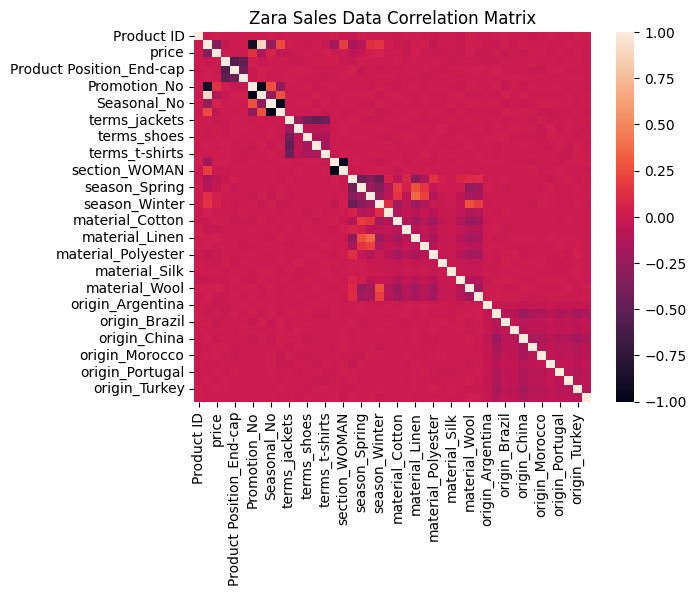

In [2]:
#preprocessing categories into numbers, and dropping the columns we won'd be using

df=df_og.copy()
df = pd.get_dummies(df, columns=['Product Position', 'Promotion', 'Seasonal', 'terms', 'section', 'season', 'material', 'origin'])

df.drop('Product Category', axis=1, inplace=True)
df.drop('brand', axis=1, inplace=True)
df.drop('url', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('currency', axis=1, inplace=True)

df = df.dropna()
correlation_matrix = df.corr()
#this plot can't show all columns, but gives some interesting information
sns.heatmap(correlation_matrix)
plt.title('Zara Sales Data Correlation Matrix')
plt.show()

0.933145816032912


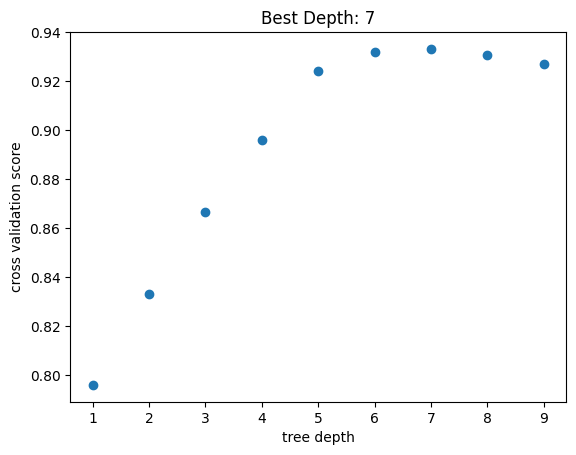

In [3]:

X = df.copy().drop('Sales Volume', axis=1)
y = df['Sales Volume']


#model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

best_depth, best_score, cv_scores = find_max_depth(X_train, y_train)
plot_best_depth(best_depth, cv_scores)




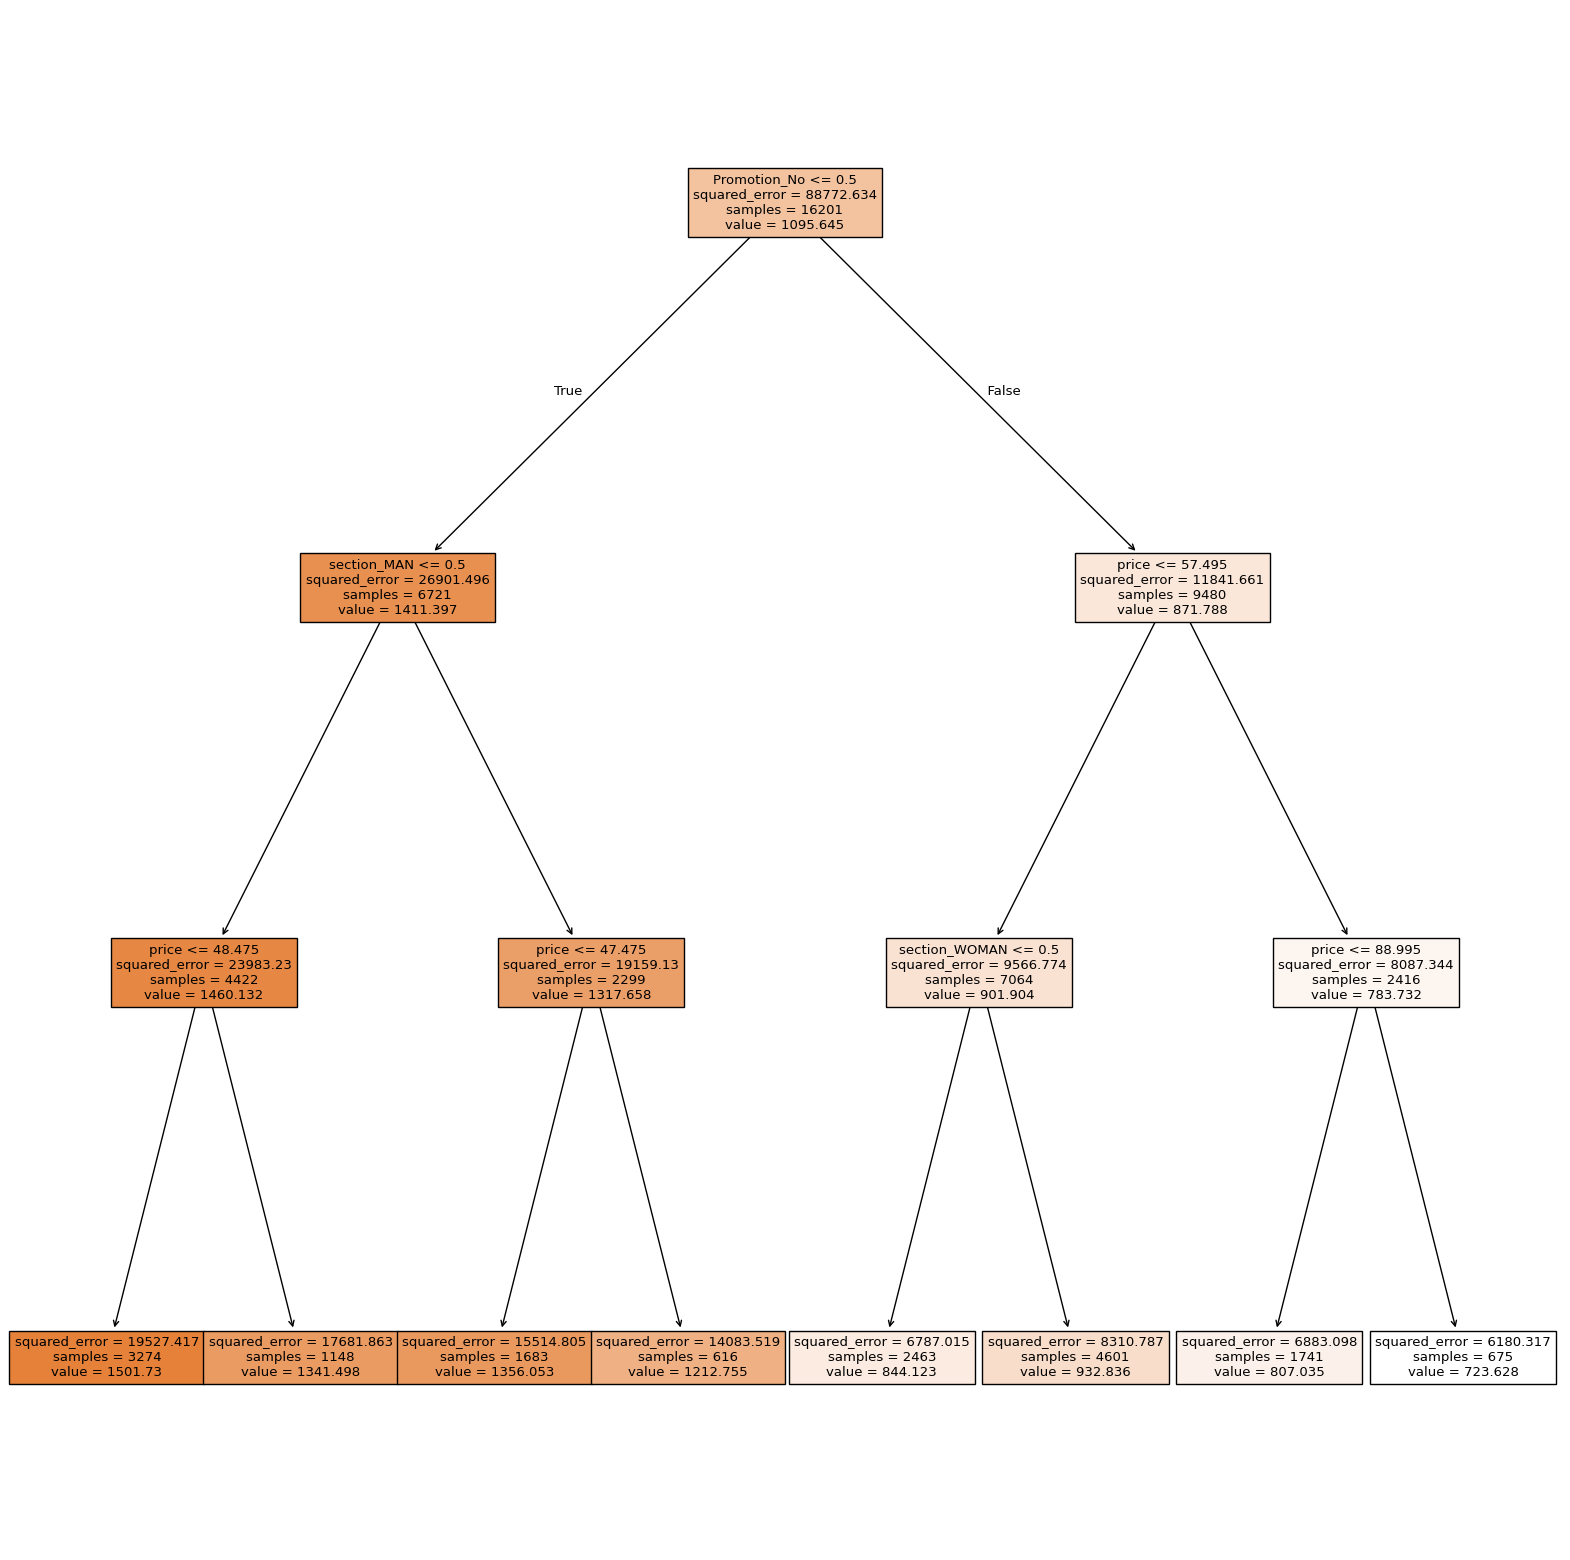

In [4]:
#creates a smaller model for an easier to read image
regressor = DecisionTreeRegressor( max_depth=3)
regressor.fit(X_train, y_train)
fig, ax = plt.subplots(1, figsize = (20, 20))
plot_tree(regressor, filled = True, feature_names = X_train.columns)
plt.show()

In [5]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=7)
regressor.fit(X_train, y_train)
print(regressor.score(X_test, y_test))
print(export_text(regressor, feature_names=X_train.columns))
#here is the whole model at the proper max depth

0.9358342051695286
|--- Promotion_Yes <= 0.50
|   |--- price <= 57.50
|   |   |--- section_WOMAN <= 0.50
|   |   |   |--- season_Winter <= 0.50
|   |   |   |   |--- season_Summer <= 0.50
|   |   |   |   |   |--- price <= 32.49
|   |   |   |   |   |   |--- price <= 22.48
|   |   |   |   |   |   |   |--- value: [836.91]
|   |   |   |   |   |   |--- price >  22.48
|   |   |   |   |   |   |   |--- value: [810.54]
|   |   |   |   |   |--- price >  32.49
|   |   |   |   |   |   |--- price <= 42.50
|   |   |   |   |   |   |   |--- value: [788.71]
|   |   |   |   |   |   |--- price >  42.50
|   |   |   |   |   |   |   |--- value: [768.78]
|   |   |   |   |--- season_Summer >  0.50
|   |   |   |   |   |--- price <= 33.47
|   |   |   |   |   |   |--- Product ID <= 202066.50
|   |   |   |   |   |   |   |--- value: [893.20]
|   |   |   |   |   |   |--- Product ID >  202066.50
|   |   |   |   |   |   |   |--- value: [933.17]
|   |   |   |   |   |--- price >  33.47
|   |   |   |   |   |   |--- Produ

In [6]:
importances = regressor.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
                            feature  importance
6                     Promotion_Yes    0.847961
1                             price    0.059367
19                    season_Winter    0.030031
18                    season_Summer    0.027180
14                      section_MAN    0.024947
15                    section_WOMAN    0.009437
0                        Product ID    0.000475
21                  material_Cotton    0.000131
22                   material_Denim    0.000097
9                     terms_jackets    0.000046
39                  origin_Portugal    0.000045
3          Product Position_End-cap    0.000041
7                       Seasonal_No    0.000037
11                      terms_shoes    0.000035
40                     origin_Spain    0.000029
8                      Seasonal_Yes    0.000023
2            Product Position_Aisle    0.000022
10                      terms_jeans    0.000020
42                   origin_Vietnam    0.000019
36                

In [8]:
#df has 44 columns, so we should knock it down a bit
#we will choose how many components to have using the following loop
for i in range(1, 43):
    pca = Standard_PCA(n_components = i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    explained_variance_ratio = pca.pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    print(i, cumulative_variance_ratio)

#we can see that 100% of the total variance can be explained by 35 columns and 80% can be explained by 26

pca = Standard_PCA(n_components = 35)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


1 [0.0601392]
2 [0.0601392  0.11052081]
3 [0.0601392  0.11052081 0.15718572]
4 [0.0601392  0.11052081 0.15718572 0.19561878]
5 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251]
6 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439]
7 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264]
8 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264 0.33685381]
9 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264 0.33685381 0.36687609]
10 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264 0.33685381 0.36687609 0.39558445]
11 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264 0.33685381 0.36687609 0.39558445 0.42398845]
12 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264 0.33685381 0.36687609 0.39558445 0.42398845 0.45218294]
13 [0.0601392  0.11052081 0.15718572 0.19561878 0.23311251 0.26968439
 0.30357264 0.33

In [ ]:
#now we're going to make this as accurate as possible
best_depth, best_score, cv_scores = find_max_depth(X_train_pca, y_train)
plot_best_depth(best_depth, cv_scores)

In [ ]:
regressor_pca = DecisionTreeRegressor(random_state=0,max_depth=8)
regressor_pca.fit(X_train_pca, y_train)
print(regressor_pca.score(X_test_pca, y_test))

#as we can see, this was less accurate than the original data
#the original data is also easier to read and interpret, so it is more useful